In [19]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from itertools import product

# Randomly seeding
tf.random.set_seed(6950)
# Constants
SAMPLING_RATE = 500  # Hz
ecg_folder = "../../../Datasets/12-lead electrocardiogram database/ECGData"
diagnostics_file = "../../../Datasets/12-lead electrocardiogram database/Diagnostics.xlsx"
# Label mapping
# Basically to reduce 11 label to 4 for better performance on chapmanecg dataset
rhythm_mapping = {
    'AFIB': 'AFIB',
    'AF': 'AFIB',
    'SVT': 'GSVT',
    'AT': 'GSVT',
    'SAAWR': 'GSVT',
    'ST': 'GSVT',
    'AVNRT': 'GSVT',
    'AVRT': 'GSVT',
    'SB': 'SB',
    'SR': 'SR',
    'SA': 'SR'
}

Detected QRS peaks:  [ 297  732 1001 1276 1531 1782 2125 2531 2821 3073 3540 3809 4077 4567
 4841] Error:  4
Detected QRS peaks:  [ 538 1097 1667 2273 2864 3433 4008 4603] Error:  0
Detected QRS peaks:  [ 416  918 1334 1726 2176 2648 3080 3498 3960 4446 4862] Error:  0
Detected QRS peaks:  [ 380  948 1499 2059 2621 3171 3742 4312 4882] Error:  0
Detected QRS peaks:  [ 146  405  687  967 1456 1889 2360 2612 2910 3277 3656 3926 4408 4776] Error:  12
Detected QRS peaks:  [ 205  746 1274 1778 2313 2866 3383 3907 4440] Error:  0
Detected QRS peaks:  [ 257  566  883 1317 1680 1990 2403 2749 3075 3329 3644 4118 4531 4924] Error:  3
Detected QRS peaks:  [ 150  717 1082 1577 2061 2543 3076 3479 3993 4499 4924] Error:  0
Detected QRS peaks:  [ 153  632 1141 1644 2140 2691 3221 3727 4251 4770] Error:  0
Detected QRS peaks:  [  75  488 1121 1536 2053 2601 3149 3683 4084 4632] Error:  0
Detected QRS peaks:  [ 184  725 1259 1796 2357 2897 3435 3984 4514] Error:  0
Detected QRS peaks:  [ 184  676  97

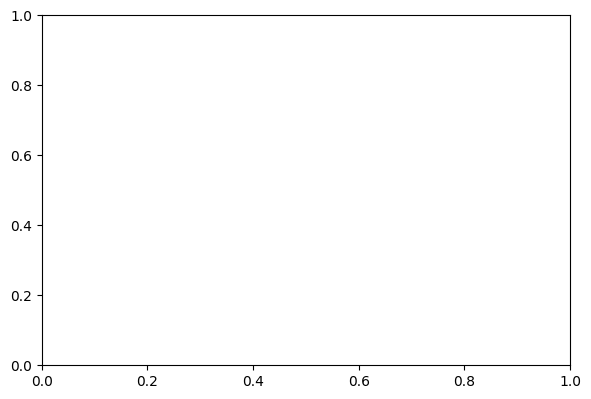

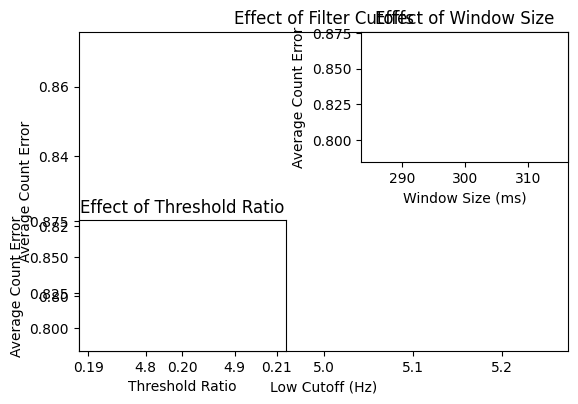

,,,,count_error
filter_low,filter_high,window_ms,threshold_ratio,
5,50,300,0.2,0.83


In [20]:

def detect_qrs_peaks(ecg_signal, sampling_rate=500, filter_low=0.5, filter_high=50,
                    window_ms=150, threshold_ratio=0.3):
    """
    QRS detection with configurable parameters

    Args:
        ecg_signal: Raw ECG signal
        sampling_rate: Sampling frequency in Hz
        filter_low: Lower cutoff frequency for bandpass
        filter_high: Upper cutoff frequency for bandpass
        window_ms: Moving window size in milliseconds
        threshold_ratio: Ratio for adaptive thresholding
    """
    # Bandpass filter
    nyquist_freq = sampling_rate / 2
    low = filter_low / nyquist_freq
    high = filter_high / nyquist_freq
    b, a = signal.butter(3, [low, high], btype='band')
    filtered_ecg = signal.filtfilt(b, a, ecg_signal)

    # Derivative
    derivative = np.diff(filtered_ecg)

    # Squaring
    squared = derivative ** 2

    # Moving window integration
    window_size = int(window_ms / 1000 * sampling_rate)
    window = np.ones(window_size) / window_size
    integrated = np.convolve(squared, window, mode='same')

    # Adaptive thresholding
    peak_threshold = threshold_ratio * np.max(integrated)

    # Find peaks
    qrs_peaks, _ = signal.find_peaks(integrated, height=peak_threshold, distance=sampling_rate//2)

    return qrs_peaks

def evaluate_parameters(ecg_data, actual_qrs_count):
    """
    Evaluate QRS detection accuracy for different parameter combinations
    """
    # Parameter ranges to test
    # filter_low_values = [0.5, 1, 2, 5]  # Hz
    # filter_high_values = [30, 40, 50]  # Hz
    # window_sizes = [100, 150, 200]  # ms
    # threshold_ratios = [0.2, 0.3, 0.4]
    filter_low_values = [5]  # Hz
    filter_high_values = [50]  # Hz
    window_sizes = [300]  # ms
    threshold_ratios = [0.2]

    results = []

    # Test all combinations
    param_combinations = product(filter_low_values, filter_high_values, window_sizes, threshold_ratios)

    for low, high, window, threshold in param_combinations:
        # Skip invalid filter combinations
        if low >= high:
            continue

        # Detect QRS peaks with current parameters
        detected_peaks = detect_qrs_peaks(
            ecg_data,
            filter_low=low,
            filter_high=high,
            window_ms=window,
            threshold_ratio=threshold
        )

        # Calculate error in QRS count
        detected_count = len(detected_peaks)
        count_error = abs(detected_count - actual_qrs_count)
        print("Detected QRS peaks: ", detected_peaks, "Error: ", count_error)
        results.append({
            'filter_low': low,
            'filter_high': high,
            'window_ms': window,
            'threshold_ratio': threshold,
            'detected_count': detected_count,
            'count_error': count_error
        })

    return pd.DataFrame(results)

# Load sample data and diagnostics
diagnostics = pd.read_excel(diagnostics_file)
results_all = []

# Process first 100 files for parameter tuning
for idx, row in diagnostics.head(100).iterrows():
    file_path = os.path.join(ecg_folder, row['FileName'] + '.csv')
    if os.path.exists(file_path):
        # Load ECG data, skip header row, use lead II (column 1)
        ecg_data = np.loadtxt(file_path, delimiter=',', skiprows=1)[:, 1]

        # Evaluate parameters
        results = evaluate_parameters(ecg_data, row['QRSCount'])
        results['file'] = row['FileName']
        results_all.append(results)

# Combine results
all_results = pd.concat(results_all)

# Aggregate results across files
summary = all_results.groupby(['filter_low', 'filter_high', 'window_ms', 'threshold_ratio'])[['count_error']].mean()
summary = summary.sort_values('count_error')

# Print top 10 parameter combinations
print("\nTop 10 Parameter Combinations:")
print(summary.head(10))

# Get best parameters
best_params = summary.iloc[0].name
print("\nBest Parameters:")
print(f"Low Cutoff: {best_params[0]} Hz")
print(f"High Cutoff: {best_params[1]} Hz")
print(f"Window Size: {best_params[2]} ms")
print(f"Threshold Ratio: {best_params[3]}")

# Visualize parameter effects
plt.figure(figsize=(15, 10))

# Plot effect of filter cutoffs
plt.subplot(2, 2, 1)
filter_effect = summary.reset_index().groupby(['filter_low', 'filter_high'])['count_error'].mean()
filter_effect.unstack().plot(title='Effect of Filter Cutoffs')
plt.xlabel('Low Cutoff (Hz)')
plt.ylabel('Average Count Error')

# Plot effect of window size
plt.subplot(2, 2, 2)
window_effect = summary.reset_index().groupby('window_ms')['count_error'].mean()
window_effect.plot(title='Effect of Window Size')
plt.xlabel('Window Size (ms)')
plt.ylabel('Average Count Error')

# Plot effect of threshold ratio
plt.subplot(2, 2, 3)
threshold_effect = summary.reset_index().groupby('threshold_ratio')['count_error'].mean()
threshold_effect.plot(title='Effect of Threshold Ratio')
plt.xlabel('Threshold Ratio')
plt.ylabel('Average Count Error')

plt.tight_layout()
plt.show()

summary